In [1]:
!pip install transformers
!pip install simpletransformers

     |████████████████████████████████| 2.1 MB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.3 MB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 895 kB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 284 kB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 213 kB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 120 kB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 8.2 MB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 220 kB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 308 kB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 43 kB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 15.7 MB 4.6 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 69 kB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 5.1

In [66]:
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
# import ipdb


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertModel, BertConfig
import logging

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [67]:
documents_train = pd.read_csv("data_round_1/documents_en_train.csv")
sentences_train = pd.read_csv("data_round_1/sentences_en_train.csv")

documents_val = pd.read_csv("data_round_1/documents_en_val.csv")
sentences_val = pd.read_csv("data_round_1/sentences_en_val.csv")

documents_test = pd.read_csv("data_round_1/documents_en_test.csv")
sentences_test = pd.read_csv("data_round_1/sentences_en_test.csv")
#immap_sector_name_to_id.json

In [68]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [69]:
device

device(type='cpu')

## Investigate Document data

In [70]:
documents_train.head()

,project_name,country_code,lang_code,doc_id,doc_text,doc_url
0,IMMAP/DFS Syria,SYR,en,48582,This website uses cookies to improve your expe...,https://www.syriahr.com/en/203844/
1,IMMAP/DFS Syria,SYR,en,41032,Please enable Cookies and reload the page.\n\n...,https://www.syriahr.com/en/187230/
2,IMMAP/DFS Burkina Faso,BFA,en,41306,When Burkina Faso’s government called for civi...,https://www.thenewhumanitarian.org/news-featur...
3,IMMAP/DFS Syria,SYR,en,43779,DAMASCUS – The United Nations World Food Progr...,https://reliefweb.int/report/syrian-arab-repub...
4,IMMAP/DFS Nigeria,NGA,en,42212,Overview The continuation of conflict in North...,https://reliefweb.int/sites/reliefweb.int/file...


## Investigate full text data

In [71]:
sentences_train.head()

,doc_id,sentence_id,sentence_text,is_relevant,sector_ids
0,51657,0,New Salesian youth center in La Cecilia distri...,0,[]
1,51657,1,Armenia is at the center of the Colombian coff...,0,[]
2,51657,2,The new youth center has served more than 100 ...,0,[]
3,51657,3,The Salesian youth center was developed in res...,0,[]
4,51657,4,Many of these youth come from poor families an...,0,[]


In [72]:
counts = sentences_train[["sentence_id", "doc_id"]].groupby("doc_id").count()
print("Median sentence lenght of document:", np.median(counts))
counts

Median sentence lenght of document: 24.0


,sentence_id
doc_id,
34512,126
34513,296
34547,750
34549,65
34550,36
...,...
51845,4
51850,22
51851,3


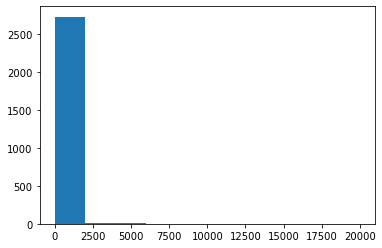

In [73]:
import matplotlib.pyplot as plt
counts = sentences_train.groupby("doc_id").count()
x = counts["sentence_id"]
plt.hist(x)
plt.show()

In [74]:
all_sectors = []
string_list = ["[", "]", ",", " "]
for topics in sentences_train["sector_ids"]:
    for topic in topics:
        if topic not in string_list:
            all_sectors.append(topic)        

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


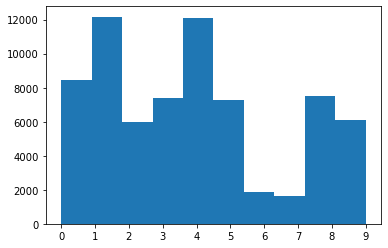

In [75]:
plt.hist(sorted(all_sectors))
plt.show()

In [76]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

In [79]:
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [80]:
sentences_train['sentence_text']

0         New Salesian youth center in La Cecilia distri...
1         Armenia is at the center of the Colombian coff...
2         The new youth center has served more than 100 ...
3         The Salesian youth center was developed in res...
4         Many of these youth come from poor families an...
                                ...                        
261976    However, humanitarian exemptions are not alway...
261977    In Iraq, there are reports of exemptions from ...
261978    The ACAPS team will keep monitoring the impact...
261979    You can find an overview of all ACAPS resource...
261980    11 ACAPS HUMANITARIAN ACCESS OVERVIEW JULY 202...
Name: sentence_text, Length: 261981, dtype: object

In [81]:
train_df = pd.DataFrame({
    'text': sentences_train['sentence_text'],
    'label': sentences_train["is_relevant"]
})

In [82]:
eval_df = pd.DataFrame({
    'text': sentences_val['sentence_text'],
    'label': sentences_val["is_relevant"],
})

In [83]:
# Optional model configuration
model_args = ClassificationArgs(num_train_epochs=1)

In [84]:
# Create a TransformerModel
model = ClassificationModel('distilbert', 'distilbert-base-uncased', use_cuda=False)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [90]:
# Train the model
model.train_model(train_df, overwrite_output_dir=True)

ValueError: Output directory (outputs/) already exists and is not empty. Set overwrite_output_dir: True to automatically overwrite.

In [31]:
CUDA_LAUNCH_BLOCKING=1

In [36]:
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

/Users/mantasbandonis/opt/miniconda3/lib/python3.8/site-packages/simpletransformers/classification/classification_model.py:1028: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_2_2


INFO:simpletransformers.classification.classification_model:{'mcc': 0.036189933645087824, 'tp': 56, 'tn': 32056, 'fp': 126, 'fn': 4871, 'auroc': 0.7085136170615378, 'auprc': 0.24630578600612157, 'eval_loss': 0.537570256509496}


In [45]:
result

{'mcc': 0.036189933645087824,
 'tp': 56,
 'tn': 32056,
 'fp': 126,
 'fn': 4871,
 'auroc': 0.7085136170615378,
 'auprc': 0.24630578600612157,
 'eval_loss': 0.537570256509496}

In [41]:
predictions, raw_outputs = model.predict(sentences_test['sentence_text'].astype(str).values.tolist())

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


In [43]:
len(predictions)

56689

In [93]:
submit_df = pd.DataFrame({
    'doc_id': sentences_test['doc_id'],
    'sentence_id': sentences_test["sentence_id"],
    'is_relevant': predictions,
})

In [94]:
submit_df.to_csv("submissions/submission_relevant_baseline", index=False)